In [225]:
!pip install torchsummary
from __future__ import print_function
from torchvision import datasets, transforms
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [226]:
def data_loader(batch_size):
  torch.manual_seed(1)

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ])),
      batch_size=batch_size, shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ])),
      batch_size=batch_size, shuffle=True, **kwargs)

  return train_loader, test_loader

In [227]:
def train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph):
    model.train()
    train_loss = 0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset), accuracy
        ))
    
    train_loss_graph.append(train_loss)
    train_accuracy_graph.append(accuracy)
    return train_loss_graph, train_accuracy_graph, accuracy

In [228]:
def test(model, device, test_loader, test_loss_graph, test_accuracy_graph):
    model.eval()
    test_loss = 0
    correct = 0
    flg = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Saving misclassified Images and their actual and pedicted labels
            tgt = target.view_as(pred)
            comp_df= pred.eq(tgt)
            mis_c = ~comp_df
            if flg == 0:
                misc_im = data[mis_c]
                misc_tr = tgt[mis_c]
                misc_pred = pred[mis_c]
                flg =1
            else:  
                misc_im = torch.cat((data[mis_c],misc_im))
                misc_tr = torch.cat((tgt[mis_c],misc_tr))
                misc_pred = torch.cat((pred[mis_c],misc_pred))            

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy
        ))
    test_loss_graph.append(test_loss)
    test_accuracy_graph.append(accuracy)
    return test_loss_graph, test_accuracy_graph, misc_im,misc_tr,misc_pred

In [229]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [230]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA6/python_files/')
import BN, LN, GN

In [231]:
def show_misclassified_images( misc_im,misc_tr,misc_pred, norm_type):

  fig=plt.figure(figsize=(4, 10))
  columns = 2
  rows = 5
  for i in range(1, columns*rows +1):
      img = misc_im[i-1]
      p = misc_pred[i-1]
      t = misc_tr[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img) 
      plt.axis('off')
      plt.title("Pred:"+str(p)[7:8]+"  Act: "+str(t)[7:8])
  plt.show()

In [232]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
batch_size = 128

def arg_expanded(arg):
  if arg == 'BN':
    return "Batch Normalization"
  if arg == 'GN':
    return "Group Normalization"
  if arg == 'LN':
    return "Layer Normalization"

def run_nw(model, arg, train_loader,test_loader):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)
  arg_full = arg_expanded(arg)
  print("\n\n================================{}================================\n".format(arg_full))
  summary(model, input_size=(1, 28, 28))
  train_loss_graph = []
  train_accuracy_graph = []
  test_loss_graph = []
  test_accuracy_graph = []
  for epoch in range(1, 21):
      print('EPOCH ', epoch)
      train_loss_graph, train_accuracy_graph, accuracy = train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph)
      scheduler.step(accuracy)


      test_loss_graph, test_accuracy_graph, misc_im,misc_tr,misc_pred = test(model, device, test_loader, test_loss_graph, test_accuracy_graph)
  
  return test_loss_graph, test_accuracy_graph, misc_im,misc_tr,misc_pred

def main(args):
  test_loss_graph_list, test_accuracy_graph_list = [], []
  train_loader,test_loader =  data_loader(batch_size)
  if arg == 'GN':
    model = GN.Net().to(device)
    _, _, _, _, _ = run_nw(model, arg, train_loader,test_loader)
  elif arg == 'BN':
    model = BN.Net().to(device)
    _, _, _, _, _ = run_nw(model, arg, train_loader,test_loader)
  elif arg == 'LN':
    model = LN.Net().to(device)
    _, _, _, _, _ = run_nw(model, arg, train_loader,test_loader)
  elif arg == 'ALL':

    model = GN.Net().to(device)
    test_loss_graph, test_accuracy_graph,  misc_im,misc_tr,misc_pred = run_nw(model, "GN", train_loader,test_loader)
    test_loss_graph_list.append(test_loss_graph), test_accuracy_graph_list.append(test_accuracy_graph)
    show_misclassified_images( misc_im,misc_tr,misc_pred, "GN")

    model = BN.Net().to(device)
    test_loss_graph, test_accuracy_graph, misc_im,misc_tr,misc_pred = run_nw(model, "BN", train_loader,test_loader)
    test_loss_graph_list.append(test_loss_graph), test_accuracy_graph_list.append(test_accuracy_graph)
    show_misclassified_images( misc_im,misc_tr,misc_pred, "BN")

    model = LN.Net().to(device)
    test_loss_graph, test_accuracy_graph, misc_im,misc_tr,misc_pred = run_nw(model, "LN", train_loader,test_loader)
    test_loss_graph_list.append(test_loss_graph), test_accuracy_graph_list.append(test_accuracy_graph)
    show_misclassified_images( misc_im,misc_tr,misc_pred, "LN")

    plt.figure(figsize=(10,5))
    plt.title("Test Loss of all 3 models")
    plt.plot(test_loss_graph_list[0],label="Loss GN")
    plt.plot(test_loss_graph_list[1],label="Loss BN")
    plt.plot(test_loss_graph_list[2],label="Loss LN")    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title("Test Acc of all 3 models")
    plt.plot(test_accuracy_graph_list[0],label="Acc GN")
    plt.plot(test_accuracy_graph_list[1],label="Acc BN")
    plt.plot(test_accuracy_graph_list[2],label="Acc LN")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
  else:
    print('Unknown input argument passed by user.')



================================Group Normalization================================

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
         GroupNorm-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,152
             ReLU-11           [-1, 16, 14, 14]               0
        GroupNorm-12           [-1, 16, 14, 14]              32
          Dropou

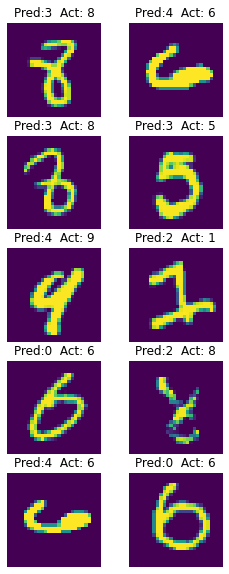



================================Batch Normalization================================

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,152
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropou

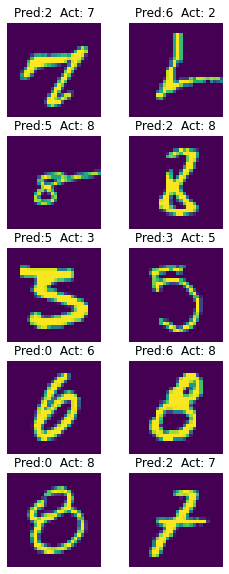



================================Layer Normalization================================

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
         LayerNorm-3            [-1, 8, 28, 28]          12,544
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
         LayerNorm-7            [-1, 8, 28, 28]          12,544
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,152
             ReLU-11           [-1, 16, 14, 14]               0
        LayerNorm-12           [-1, 16, 14, 14]           6,272
          Dropou

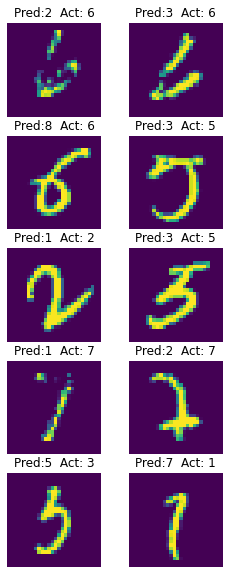

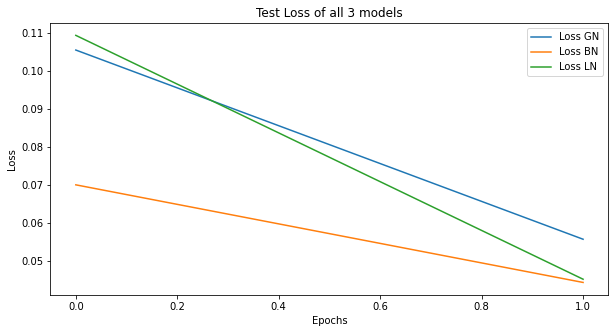

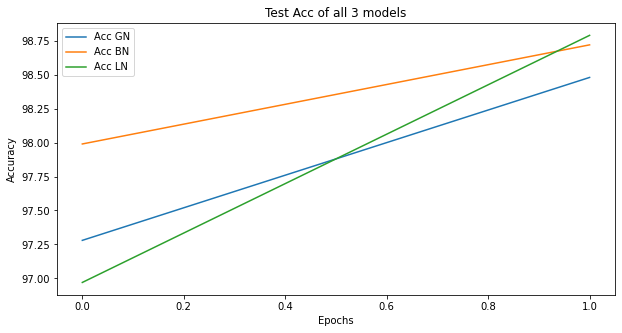

In [233]:
import argparse
import matplotlib.pyplot as plt

if __name__ == '__main__':
    args = argparse.ArgumentParser(description='PyTorch Template')
    args.add_argument('-n', '--norm', default=None, type=str,
                      help='GN/BN/LN/ALL to select which kind of normalization to run. ALL option is to run all normalizations in a loop(default: None)')
    args = args.parse_args(['-n', 'ALL'])
    args_dict = vars(args)
    arg = args_dict['norm']
    main(arg)
